In [25]:
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import random
from PIL import Image

In [2]:
onnx_model = onnx.load("runs/train/yolov7-tiny/weights/best.onnx")  # load onnx model

tf_path = "yolov7_tiny_tf"
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph(tf_path)  # export the model

2023-03-19 02:55:54.363501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 02:55:54.364047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 02:55:54.368583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 02:55:54.369111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 02:55:54.369431: I tensorflow/compiler/xla/stream_executo

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Assets written to: yolov7_tiny_tf/assets


INFO:tensorflow:Assets written to: yolov7_tiny_tf/assets


In [3]:
converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#                           tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
# converter.representative_dataset = representative_data_gen
converter.target_spec.supported_types = [tf.float32]
tflite_model = converter.convert()

2023-03-19 02:56:05.634621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-19 02:56:05.634645: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-19 02:56:05.635134: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: yolov7_tiny_tf
2023-03-19 02:56:05.643556: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-19 02:56:05.643583: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: yolov7_tiny_tf
2023-03-19 02:56:05.667048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-19 02:56:05.671582: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-19 02:56:05.767547: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: yolov7_tiny_tf
2023-03-19 02

In [4]:
with open('yolov7-tiny.tflite', 'wb') as f:
    f.write(tflite_model)

In [5]:
interpreter = tf.lite.Interpreter(model_path='yolov7-tiny.tflite', num_threads=4)
interpreter.resize_tensor_input(0, tensor_size=[1,3,640,640])
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
interpreter.get_input_details()[0]

{'name': 'serving_default_images:0',
 'index': 0,
 'shape': array([  1,   3, 640, 640], dtype=int32),
 'shape_signature': array([  1,   3, 640, 640], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [8]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

In [35]:
img = cv2.imread('../datasets/VisDrone/VisDrone2019-DET-val/images/0000001_02999_d_0000005.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640,640))
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = tf.transpose(image, perm=[2,0,1])
image = tf.expand_dims(image, axis=0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255.0

In [37]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
t0 = time.time()
interpreter.set_tensor(input_index, im)
interpreter.invoke()
t1 = time.time()
pred = interpreter.get_tensor(output_index)

In [38]:
names= [
    'pedestrian',
    'people',
    'bicycle',
    'car',
    'van',
    'truck',
    'tricycle',
    'awning-tricycle',
    'bus',
    'motor'
]
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}


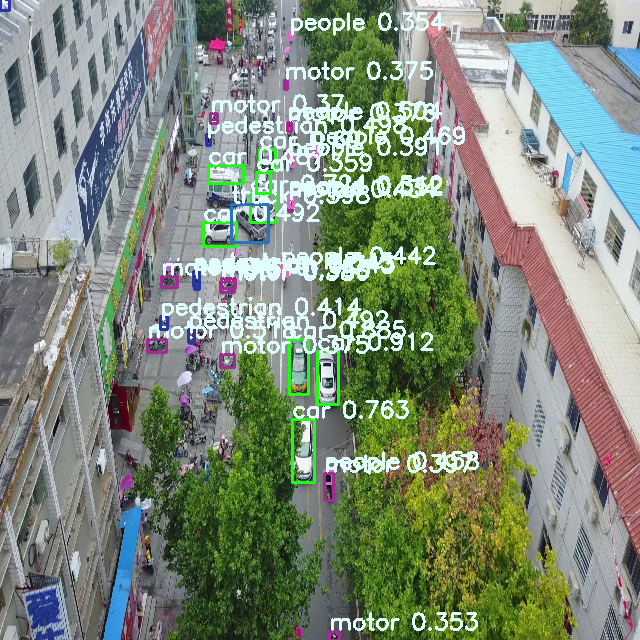

In [40]:
outputs = pred
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])